In [1]:
import torch
import sys
import matplotlib as mpl
from matplotlib import pyplot as plt
from torch import vmap
import seaborn as sns
import numpy as np
from math import pi
import time


## nice defaults
%matplotlib inline
mpl.rcParams['axes.grid']  = True
mpl.rcParams['axes.grid.which']  = 'both'
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['ytick.minor.visible']  = True
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = '0.8'
mpl.rcParams['grid.alpha'] = '0.5'
mpl.rcParams['figure.figsize'] = (8, 4)
mpl.rcParams['figure.titlesize'] = 12.5
mpl.rcParams['font.size'] = 12.5
mpl.rcParams['legend.fontsize'] = 12.5
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.usetex'] = False


sys.path.append('../')
import interflow as itf
import interflow.fabrics as fabrics
import interflow.gmm as gmm
import interflow.stochastic_interpolant as stochastic_interpolant


%load_ext autoreload
%autoreload 2


if torch.cuda.is_available():
    device = 'cuda'
    print('Using GPU.')
else:
    device = 'cpu'
    print('Using the cpu. No GPU!')

Using GPU.


## Utility functions

In [2]:
def setup_random_covs(N: int, d: int):
    Cs = torch.zeros(N, d, d)
    for ii in range(N):
        C = torch.randn(d, d)
        Cs[ii] = (C.T @ C + 0.5*torch.eye(d))
    
    return Cs


def setup_random_means(N: int, d: int, scale: float):
    return scale*torch.randn((N, d))

## Setup interpolant

In [3]:
torch.manual_seed(12)

d           = 2
N0          = 1
N1          = 3
scale       = 3
gamma_type  = 'brownian'
path        = 'linear'
p0s         = (torch.ones(N0) / N0).to(device)
p1s         = (torch.ones(N1) / N1).to(device)
mu0s        = setup_random_means(N0, d, scale).to(device)
mu1s        = setup_random_means(N1, d, scale).to(device)
C0s         = setup_random_covs(N0, d).to(device)
C1s         = setup_random_covs(N1, d).to(device)

interpolant = gmm.GMMInterpolant(
    p0s, p1s, mu0s, mu1s, C0s, C1s, path, gamma_type, device
)

## Sample from base and target

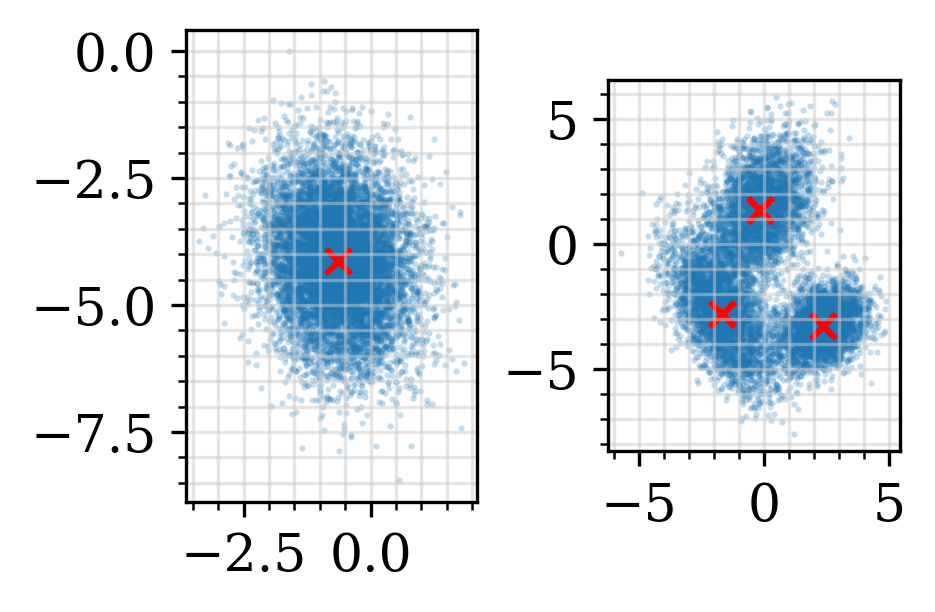

In [4]:
nsamples = 10000
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(3,2))
rho0_samples = interpolant.sample_rho0(nsamples)
rho1_samples = interpolant.sample_rho1(nsamples)

for ax in axs:
    ax.set_aspect(1.0)

axs[0].scatter(rho0_samples[:, 0].cpu().numpy(), 
               rho0_samples[:, 1].cpu().numpy(), s=0.25, alpha=0.25)
axs[1].scatter(rho1_samples[:, 0].cpu().numpy(), 
               rho1_samples[:, 1].cpu().numpy(), s=0.25, alpha=0.25)

axs[0].scatter(mu0s[:, 0].cpu().numpy(), 
               mu0s[:, 1].cpu().numpy(), color='red', marker='x')
axs[1].scatter(mu1s[:, 0].cpu().numpy(), 
               mu1s[:, 1].cpu().numpy(), color='red', marker='x')

## Pushforward samples and compute likelihoods for SDE and ODE

In [5]:
n_save       = 5
n_step       = 100
n_likelihood = 5
start_end    = (0.0001,0.9999)
b, s         = interpolant.get_velocities()
b, s         = fabrics.InputWrapper(b), fabrics.InputWrapper(s)
epsilon      = torch.tensor(2.0).to(device)


diff_interp  = stochastic_interpolant.Interpolant(path, gamma_type)


sde_flow = stochastic_interpolant.SDEIntegrator(
    b,
    s,
    epsilon,
    diff_interp,
    n_save,
    start_end,
    n_step,
    n_likelihood
)

pflow = stochastic_interpolant.PFlowIntegrator(
    b,
    method='rk4',
    interpolant=diff_interp,
    n_step=100
)

In [6]:
bs = 10000


with torch.no_grad():
    x0s                          = interpolant.sample_rho0(bs).to(device)
    x1_hats_sde                  = sde_flow.rollout_forward(x0s, method='euler')[-1]
    x0_hats_sde, dlogps_sde      = sde_flow.rollout_likelihood(x1_hats_sde)
    likelihoods_sde = torch.mean(
        interpolant.log_rho0(x0_hats_sde.reshape(-1, d)).reshape(n_likelihood, -1), axis=0
    ) - dlogps_sde


    x1_hats_ode, likelihoods_ode = pflow.rollout(x0s)
    x1_hats_ode = x1_hats_ode[-1]
    likelihoods_ode = likelihoods_ode[-1]
    likelihoods_ode += interpolant.log_rho0(x0s)

/tmp/ipykernel_645571/1456913661.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(mappable, ax=axs.ravel().tolist(),


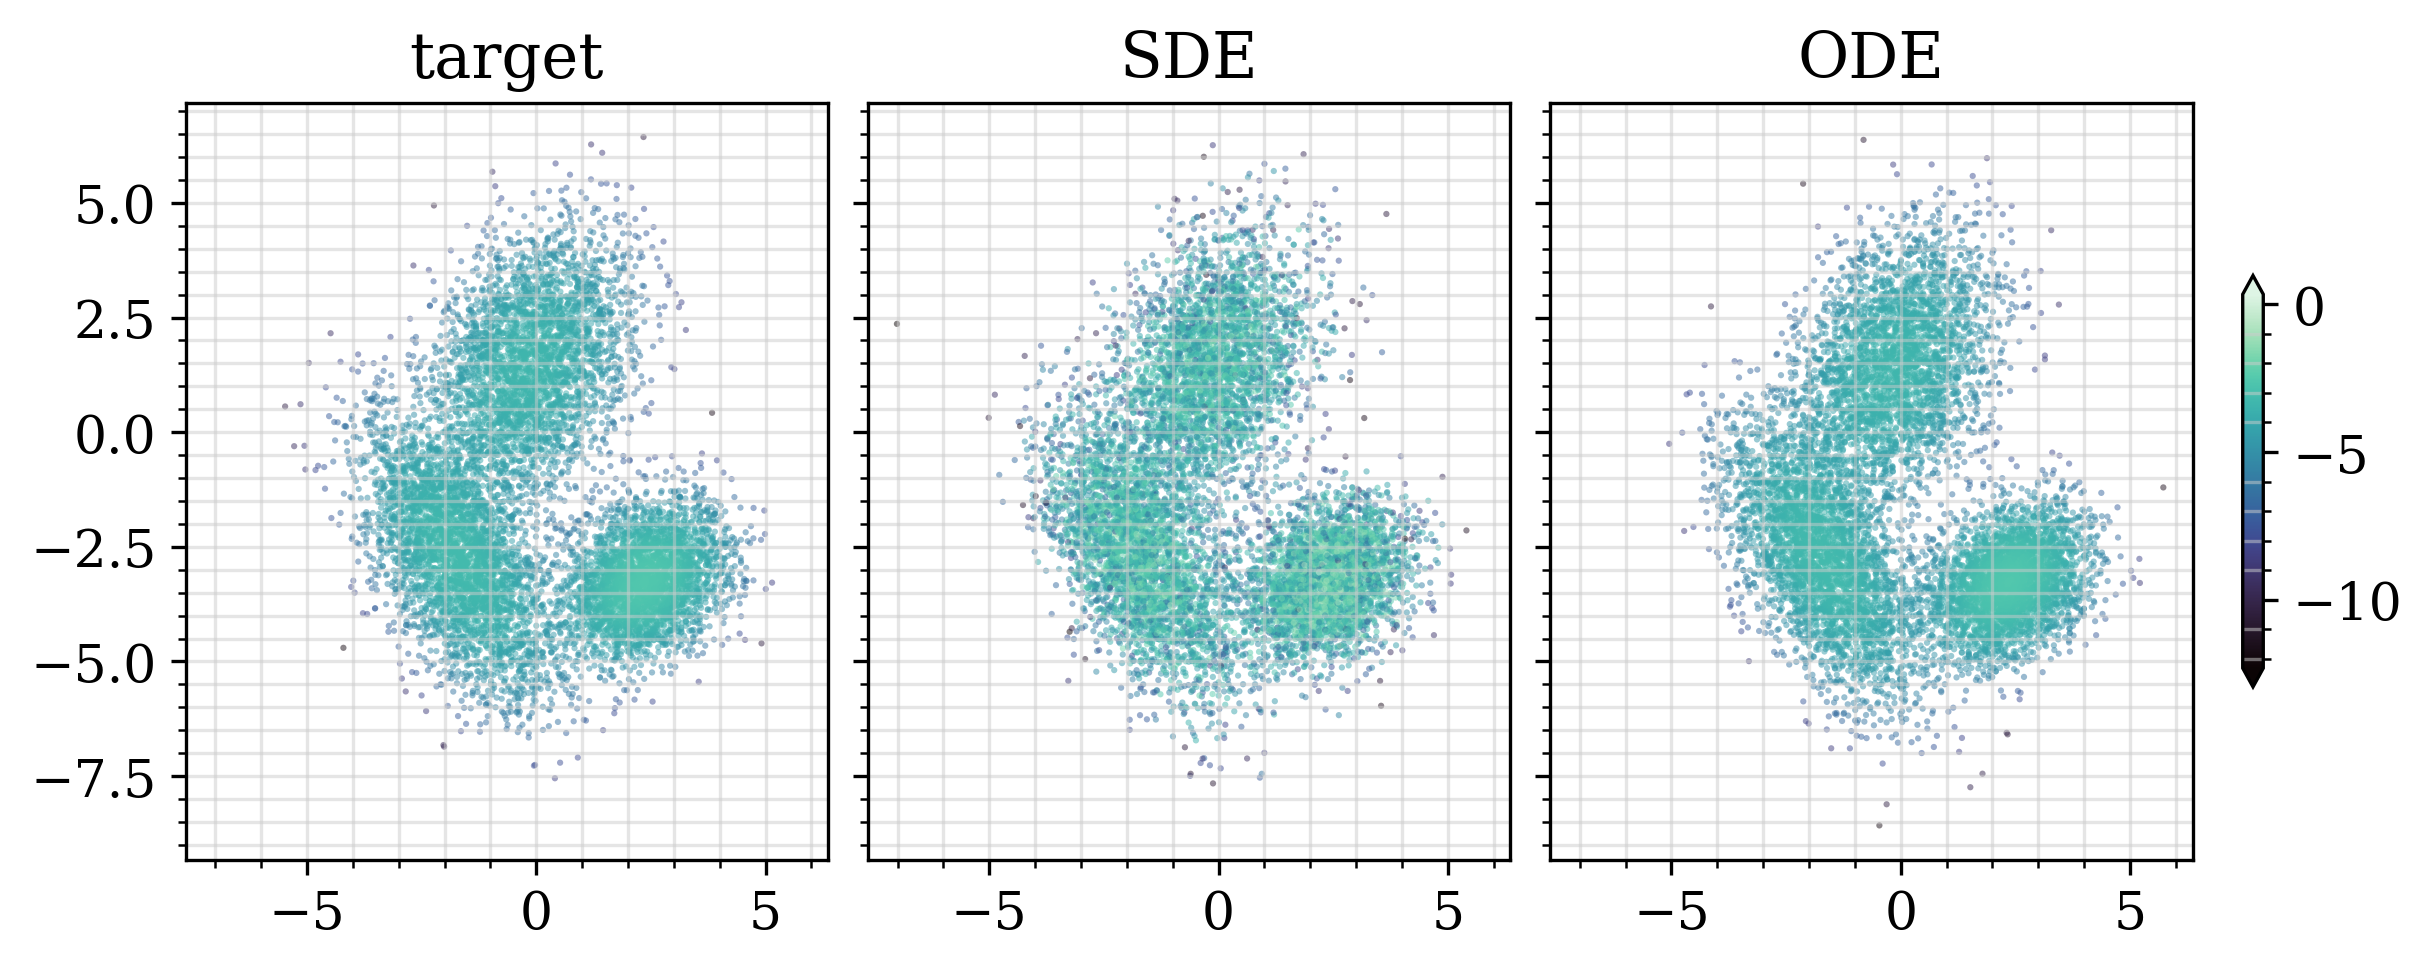

In [7]:
nsamples = 10000
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, sharex=True, sharey=True)
axs[0].set_title('target')
axs[1].set_title('SDE')
axs[2].set_title('ODE')
cmap = sns.color_palette("mako", as_cmap=True)


rho1_samples = interpolant.sample_rho1(nsamples)
rho1_likes   = interpolant.log_rho1(rho1_samples)
vmin         = 0.9*min([torch.min(rho1_likes), torch.min(likelihoods_sde), torch.min(likelihoods_ode)])
vmax         = 0.9*max([torch.max(rho1_likes), torch.max(likelihoods_sde), torch.max(likelihoods_ode)])
norm         = mpl.colors.Normalize(vmin, vmax)
mappable     = mpl.cm.ScalarMappable(norm, cmap=cmap)


axs[0].scatter(rho1_samples[:, 0].cpu().numpy(), 
               rho1_samples[:, 1].cpu().numpy(), 
               s=0.25, alpha=.5, c=rho1_likes.cpu().numpy(), cmap=cmap, norm=norm)


axs[1].scatter(x1_hats_sde[:, 0].cpu().numpy(), 
               x1_hats_sde[:, 1].cpu().numpy(), 
               s=0.25, alpha=.5, c=likelihoods_sde.cpu().numpy(), cmap=cmap, norm=norm)


axs[2].scatter(x1_hats_ode[:, 0].cpu().numpy(), 
               x1_hats_ode[:, 1].cpu().numpy(), 
               s=0.25, alpha=.5, c=likelihoods_ode.cpu().numpy(), cmap=cmap, norm=norm)


cbar = fig.colorbar(mappable, ax=axs.ravel().tolist(), 
                    location='right',
                    fraction=0.05,
                    pad=0.025,
                    shrink=0.35, 
                    extend='both')


for ax in axs.ravel():
    ax.set_aspect(1.0)

# 1d Visualizations

## Linear Interpolant: Brownian Bridge

In [8]:
d           = 1
N0          = 2
N1          = 3
epsilon     = torch.tensor(5.0).to(device)
path        = 'linear'
gamma_type  = 'brownian'
p0s         = (torch.ones(N0) / N0).to(device)
p1s         = (torch.ones(N1) / N1).to(device)
mu0s        = torch.tensor([-3.0, 3.0]).reshape((N0, d)).to(device)
C0s         = torch.tensor([0.25, 0.25]).reshape((N0, d, d)).to(device)
mu1s        = torch.tensor([-6.0, 0.0, 6.0]).reshape((N1, d)).to(device)
C1s         = torch.tensor([0.5, 0.33, 0.5]).reshape((N1, d, d)).to(device)

gmm_interpolant      = gmm.GMMInterpolant(p0s, p1s, mu0s, mu1s, C0s, C1s, path, gamma_type, device)
gmm_gam0_interpolant = gmm.GMMInterpolant(p0s, p1s, mu0s, mu1s, C0s, C1s, path,     'zero', device)

In [9]:
n_step         = 100
n_save         = n_step
n_likelihood   = 1
start_end      = (0.0001, 0.9999)
b, s           = gmm_interpolant.get_velocities()
b, s           = fabrics.InputWrapper(b), fabrics.InputWrapper(s)
b_det, s_det   = gmm_gam0_interpolant.get_velocities()
b_det, s_det   = fabrics.InputWrapper(b_det), fabrics.InputWrapper(s_det)


sde_interpolant = stochastic_interpolant.Interpolant(path, gamma_type)
sde_flow    = stochastic_interpolant.SDEIntegrator(
    b, s, epsilon, interpolant = sde_interpolant,
    n_save=n_save, start_end=start_end, n_step=n_step, n_likelihood=n_likelihood
)

pflow_interpolant = stochastic_interpolant.Interpolant(path, gamma_type)
pflow       = stochastic_interpolant.PFlowIntegrator(
              b, method='rk4', interpolant=pflow_interpolant, 
              n_step=n_save
)

pflow_gam0_interpolant = stochastic_interpolant.Interpolant(path, 'zero')
pflow_gam0        = stochastic_interpolant.PFlowIntegrator(
                    b_det, method='rk4', interpolant=pflow_gam0_interpolant, n_step=n_save
)

In [10]:
bs = int(5e3)


with torch.no_grad():
    x0s                 = gmm_gam0_interpolant.sample_rho0(bs).to(device)
    x1_hats_sde         = sde_flow.rollout_forward(x0s)
    x1_hats_ode, _      = pflow.rollout(x0s)
    x1_hats_ode_det, _  = pflow_gam0.rollout(x0s)


x1_hats_sde      = x1_hats_sde.squeeze().cpu().numpy()
x1_hats_ode      = x1_hats_ode.squeeze().cpu().numpy()
x1_hats_ode_det  = x1_hats_ode_det.squeeze().cpu().numpy()

#### Trajectories + distribution over time

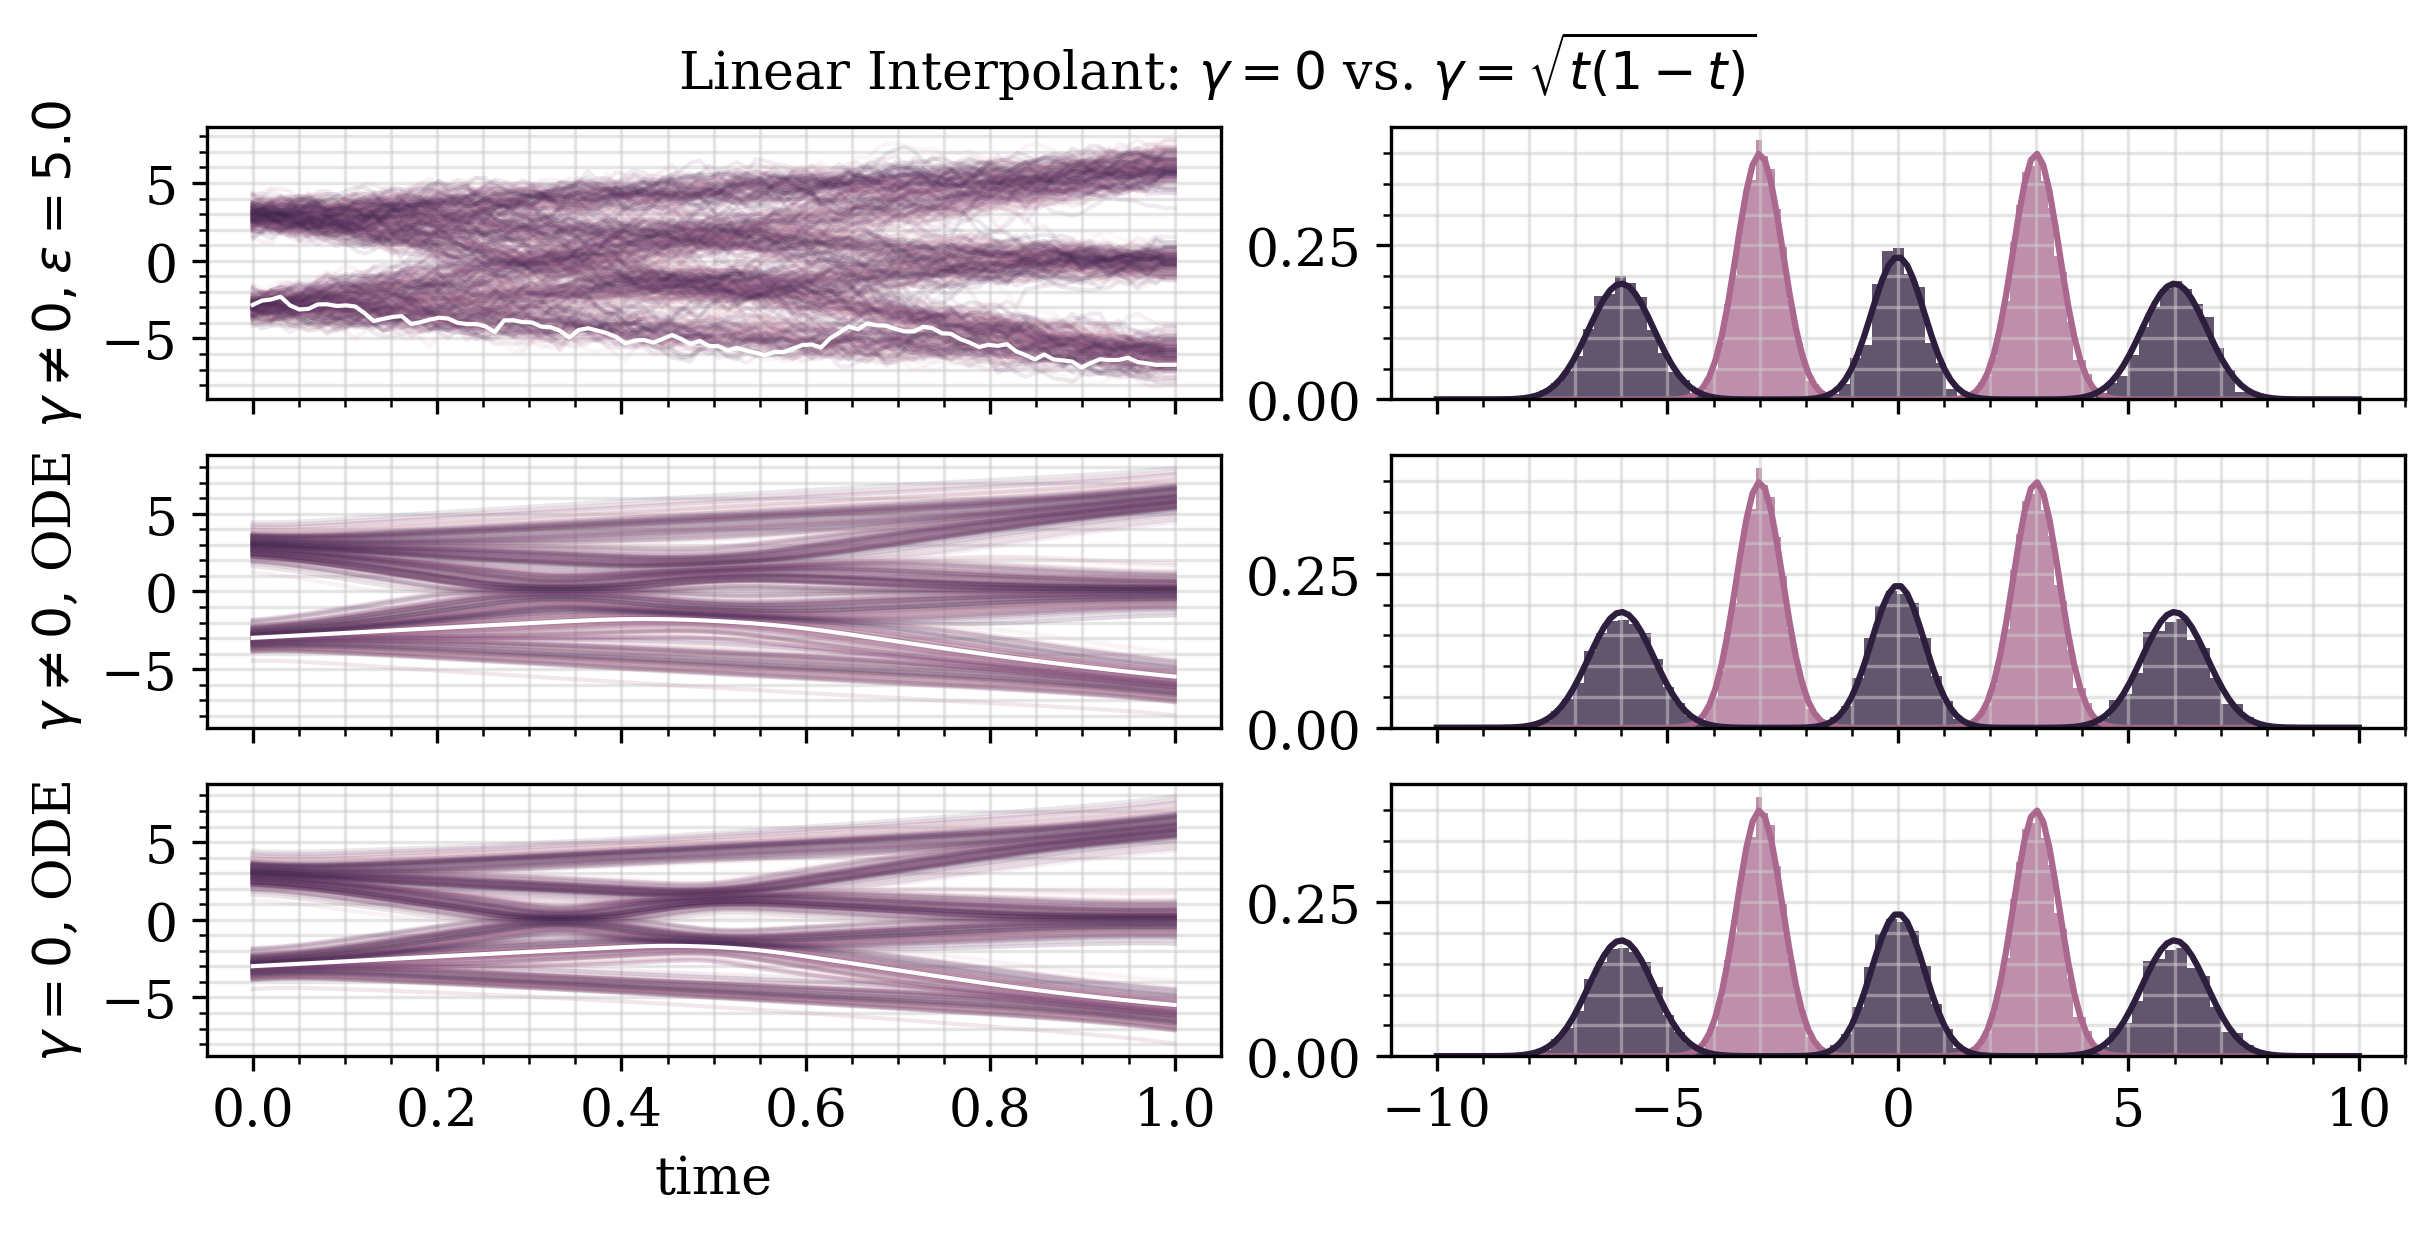

In [11]:
plt.close('all')
plot_skip    = 10
bins         = 'sqrt'
hist_index   = -1
plot_index   = np.random.randint(bs)
fig, axs     = plt.subplots(nrows=3, ncols=2, sharex='col', constrained_layout=True)
t_plots      = np.linspace(0.0, 1.0, n_save)
cmap_trajs   = sns.cubehelix_palette(n_colors=bs//plot_skip)
cmap_dists   = sns.cubehelix_palette(n_colors=3)


# grid for plotting
xs        = torch.linspace(-10, 10, 150).to(device)
rho0      = vmap(gmm_interpolant.eval_distribution, in_dims=(None, 0))(torch.tensor(0), xs).cpu().numpy()
rho1      = vmap(gmm_interpolant.eval_distribution, in_dims=(None, 0))(torch.tensor(1), xs).cpu().numpy()
fig.suptitle(r"Linear Interpolant: $\gamma=0$ vs. $\gamma = \sqrt{t(1-t)}$")


# SDE plots
axs[0, 0].set_prop_cycle('color', cmap_trajs)
axs[0, 0].set_ylabel(rf"$\gamma \neq 0, \epsilon = {epsilon}$")
_ = axs[0, 0].plot(t_plots, x1_hats_sde[:, ::plot_skip], lw=1, alpha=0.1)
_ = axs[0, 0].plot(t_plots, x1_hats_sde[:, plot_index],  lw=1, color='white', alpha=1.0)
_ = axs[0, 1].hist(x0s.cpu().numpy(), bins=bins, density=True, color=cmap_dists[1], alpha=0.75)
_ = axs[0, 1].hist(x1_hats_sde[hist_index], bins=bins, density=True, color=cmap_dists[2], alpha=0.75)
_ = axs[0, 1].plot(xs.cpu().numpy(), rho0, color=cmap_dists[1])
_ = axs[0, 1].plot(xs.cpu().numpy(), rho1, color=cmap_dists[2])


# ODE plots
axs[1, 0].set_ylabel(r"$\gamma \neq 0$, ODE")
axs[1, 0].set_prop_cycle('color', cmap_trajs)
_ = axs[1, 0].plot(t_plots, x1_hats_ode[:, ::plot_skip], lw=1, alpha=0.1)
_ = axs[1, 0].plot(t_plots, x1_hats_ode[:, plot_index],  lw=1, color='white', alpha=1.0)
_ = axs[1, 1].hist(x0s.cpu().numpy(), bins=bins, density=True, color=cmap_dists[1], alpha=0.75)
_ = axs[1, 1].hist(x1_hats_ode[hist_index], bins=bins, density=True, color=cmap_dists[2], alpha=0.75)
_ = axs[1, 1].plot(xs.cpu().numpy(), rho0, color=cmap_dists[1])
_ = axs[1, 1].plot(xs.cpu().numpy(), rho1, color=cmap_dists[2])


# ODE plots: \epsilon = 0
axs[2, 0].set_ylabel(r"$\gamma = 0$, ODE")
axs[2, 0].set_prop_cycle('color', cmap_trajs)
axs[2, 0].set_xlabel('time')
_ = axs[2, 0].plot(t_plots, x1_hats_ode_det[:, ::plot_skip], lw=1, alpha=0.1)
_ = axs[2, 0].plot(t_plots, x1_hats_ode_det[:, plot_index],  lw=1, color='white', alpha=1.0)
_ = axs[2, 1].hist(   x0s.cpu().numpy(), bins=bins, density=True, color=cmap_dists[1], alpha=0.75)
_ = axs[2, 1].hist(x1_hats_ode_det[hist_index], bins=bins, density=True, color=cmap_dists[2], alpha=0.75)
_ = axs[2, 1].plot(xs.cpu().numpy(), rho0, color=cmap_dists[1])
_ = axs[2, 1].plot(xs.cpu().numpy(), rho1, color=cmap_dists[2])

#### Distributions over time

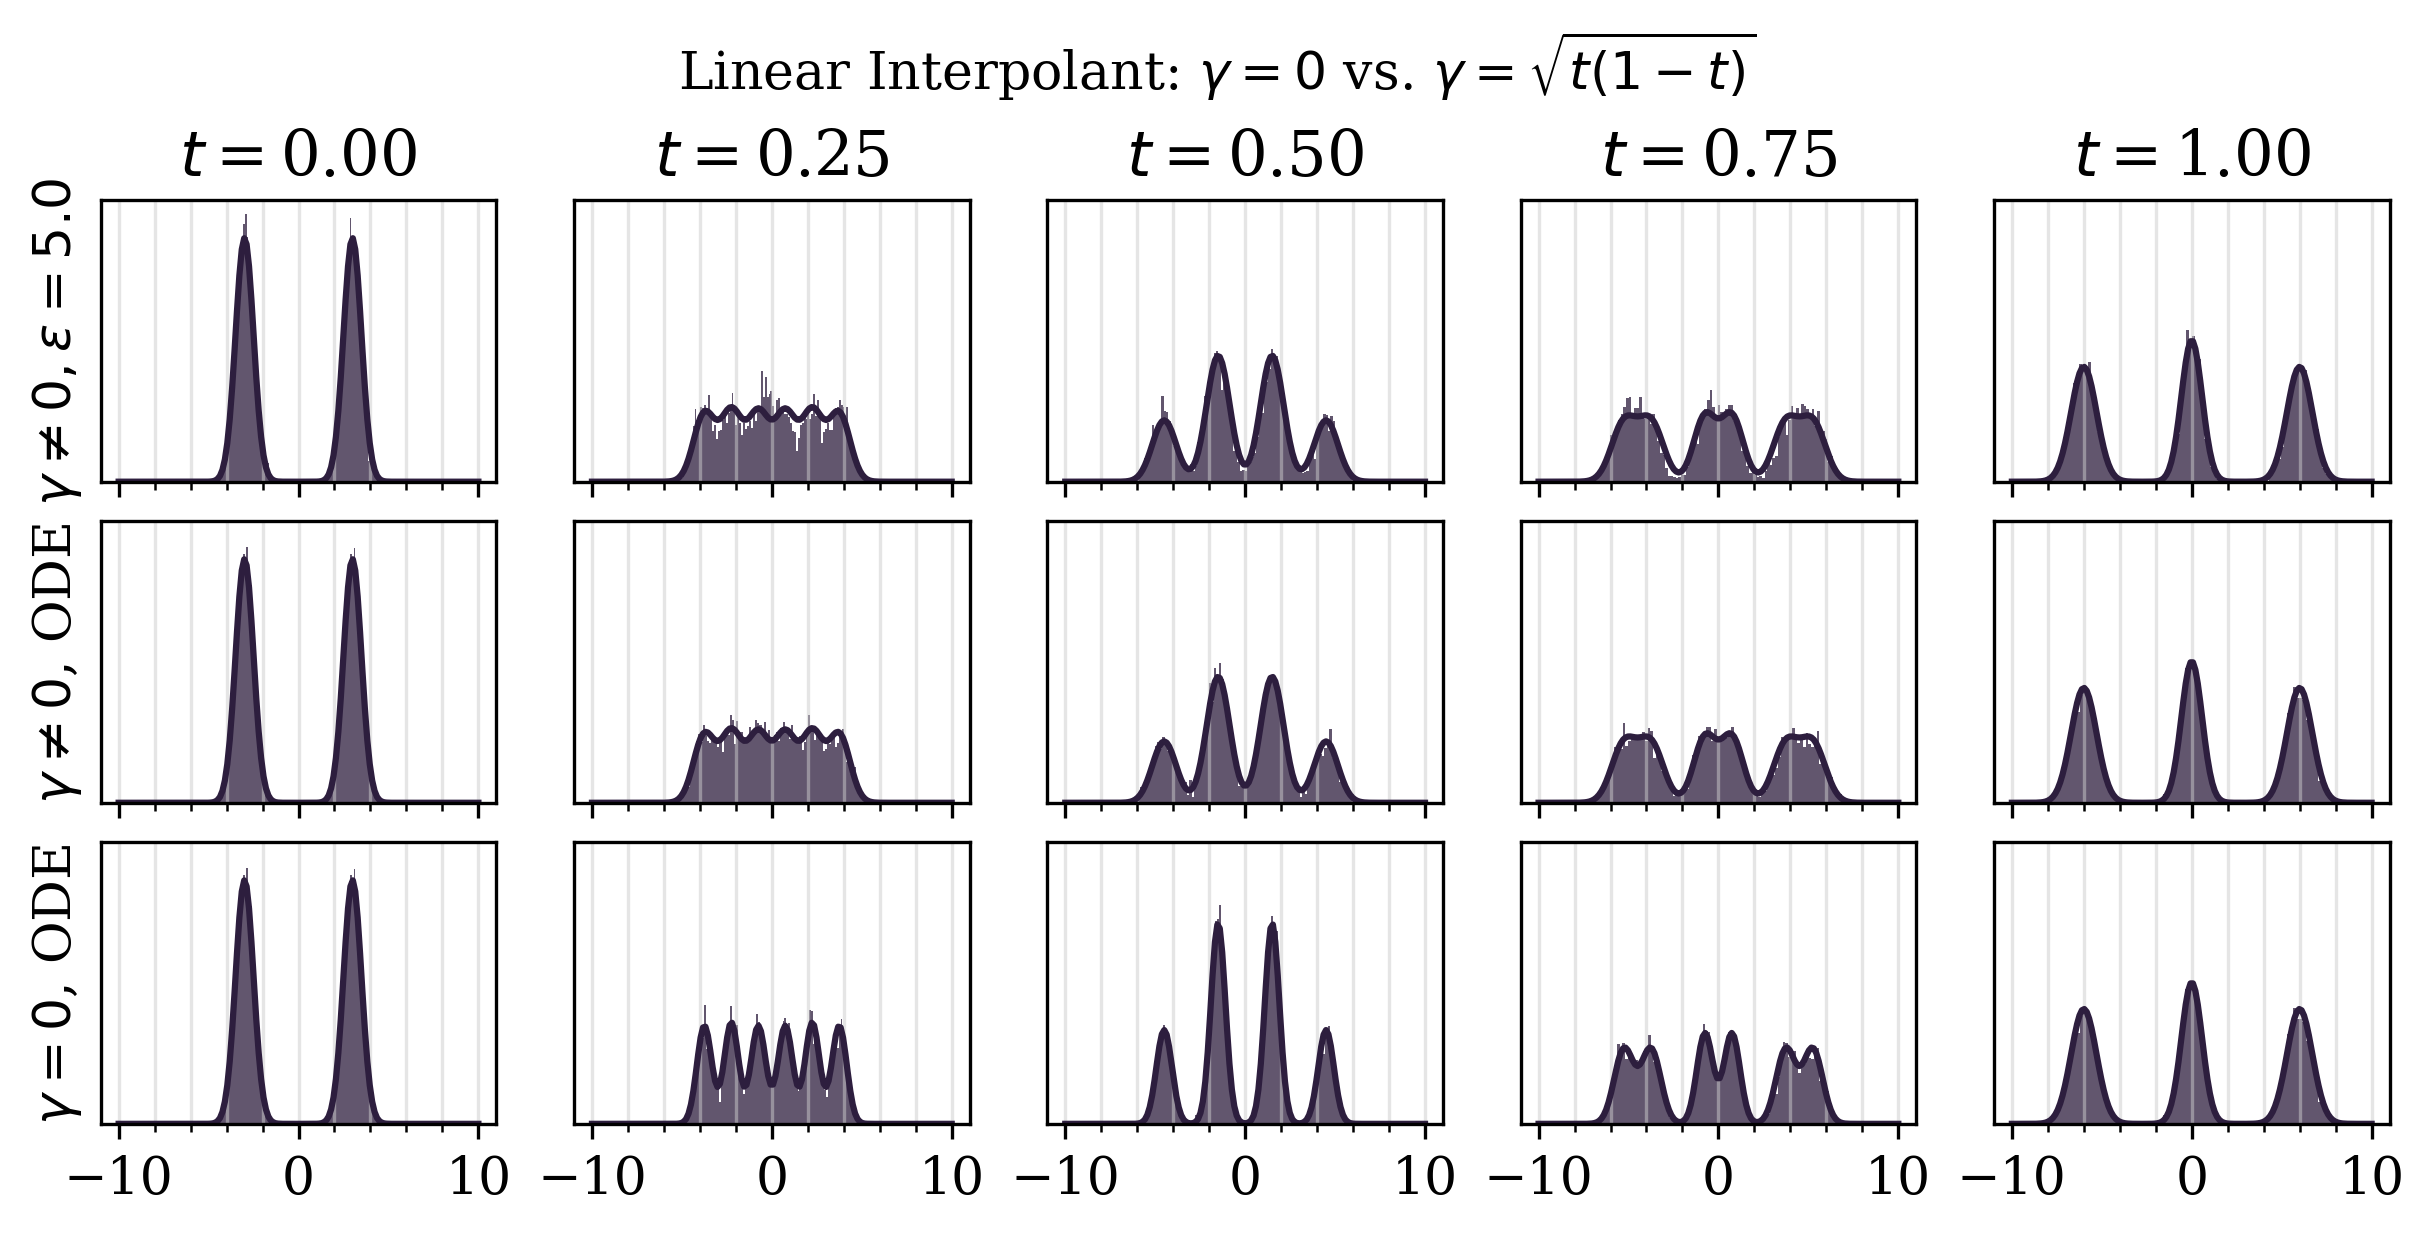

In [12]:
plt.close('all')
plot_skip     = 10
bins          = 100
n_hists       = 5
skip          = x1_hats_sde.shape[0] // (n_hists-1)
hist_indices  = list(np.arange(x1_hats_sde.shape[0])[::skip]) + [x1_hats_sde.shape[0]-1]
total_samples = [x1_hats_sde, x1_hats_ode, x1_hats_ode_det]
nrows         = len(total_samples)
ncols         = len(hist_indices)
fig, axs      = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, sharex=True, sharey=True)
t_plots       = np.linspace(0.0, 1.0, n_save)
cmap_trajs    = sns.cubehelix_palette(n_colors=bs//plot_skip)
cmap_dists    = sns.cubehelix_palette(n_colors=3)
titles        = [rf"$\gamma \neq 0, \epsilon = {epsilon}$", rf"$\gamma \neq 0$, ODE", r"$\gamma = 0$, ODE"]

dt = torch.tensor(1/n_step)
xs = torch.linspace(-10, 10, 150).to(device)
fig.suptitle(r"Linear Interpolant: $\gamma=0$ vs. $\gamma = \sqrt{t(1-t)}$")
for ii in range(nrows):
    for jj in range(ncols):
        hist_index = hist_indices[jj]
        samples = total_samples[ii][hist_index]
        t = hist_index*dt
        
        if hist_index == hist_indices[-1]:
            t += dt
        
        if ii == 0:
            axs[ii, jj].set_title(f'$t=${t:.02f}')
        
        if jj == 0:
            axs[ii, jj].set_ylabel(titles[ii])
            axs[ii, jj].set_yticks([])

        if ii == nrows-1:
            gmm_gam0_interpolant
            rhot = vmap(gmm_gam0_interpolant.eval_distribution, in_dims=(None, 0))(t, xs).cpu().numpy()
            # rhot = vmap(interpolant_det.eval_distribution, in_dims=(None, 0))(t, xs).cpu().numpy()
        else:
            rhot = vmap(gmm_interpolant.eval_distribution, in_dims=(None, 0))(t, xs).cpu().numpy()

        _ = axs[ii, jj].hist(samples, bins=bins, density=True, color=cmap_dists[2], alpha=0.75)
        _ = axs[ii, jj].plot(xs.cpu().numpy(), rhot, color=cmap_dists[2])

## Gaussian Encoder-Decoder

In [13]:
d           = 1
N0          = 2
N1          = 3
gamma_type  = 'brownian'
path        = 'encoding-decoding'
epsilon     = torch.tensor(5.0).to(device)
p0s         = (torch.ones(N0) / N0).to(device)
p1s         = (torch.ones(N1) / N1).to(device)
mu0s        = torch.tensor([-3.0, 3.0]).reshape((N0, d)).to(device)
C0s         = torch.tensor([0.25, 0.25]).reshape((N0, d, d)).to(device)
mu1s        = torch.tensor([-6.0, 0.0, 6.0]).reshape((N1, d)).to(device)
C1s         = torch.tensor([0.5, 0.33, 0.5]).reshape((N1, d, d)).to(device)
interpolant = gmm.GMMInterpolant(p0s, p1s, mu0s, mu1s, C0s, C1s, path, gamma_type, device)

In [14]:
n_step         = 100
n_save         = n_step
n_likelihood   = 1
start_end      = (0.0001, 0.9999)
bs          = int(5e3)
b, s        = interpolant.get_velocities()
b, s        = fabrics.InputWrapper(b), fabrics.InputWrapper(s)
sde_flow    = stochastic_interpolant.SDEIntegrator(
    b, s, epsilon, interpolant=stochastic_interpolant.Interpolant(path, gamma_type), 
    n_save=n_save, start_end=start_end, n_step=n_step, n_likelihood=n_likelihood
)

pflow       = stochastic_interpolant.PFlowIntegrator(
    b, method='rk4', interpolant=stochastic_interpolant.Interpolant(path, gamma_type), n_step=n_save
)


with torch.no_grad():
    x0s                 = interpolant.sample_rho0(bs).to(device)
    x1_hats_sde         = sde_flow.rollout_forward(x0s)
    x1_hats_ode, _      = pflow.rollout(x0s)


x1_hats_sde      = x1_hats_sde.squeeze().cpu().numpy()
x1_hats_ode      = x1_hats_ode.squeeze().cpu().numpy()

#### Trajectories + Distributions

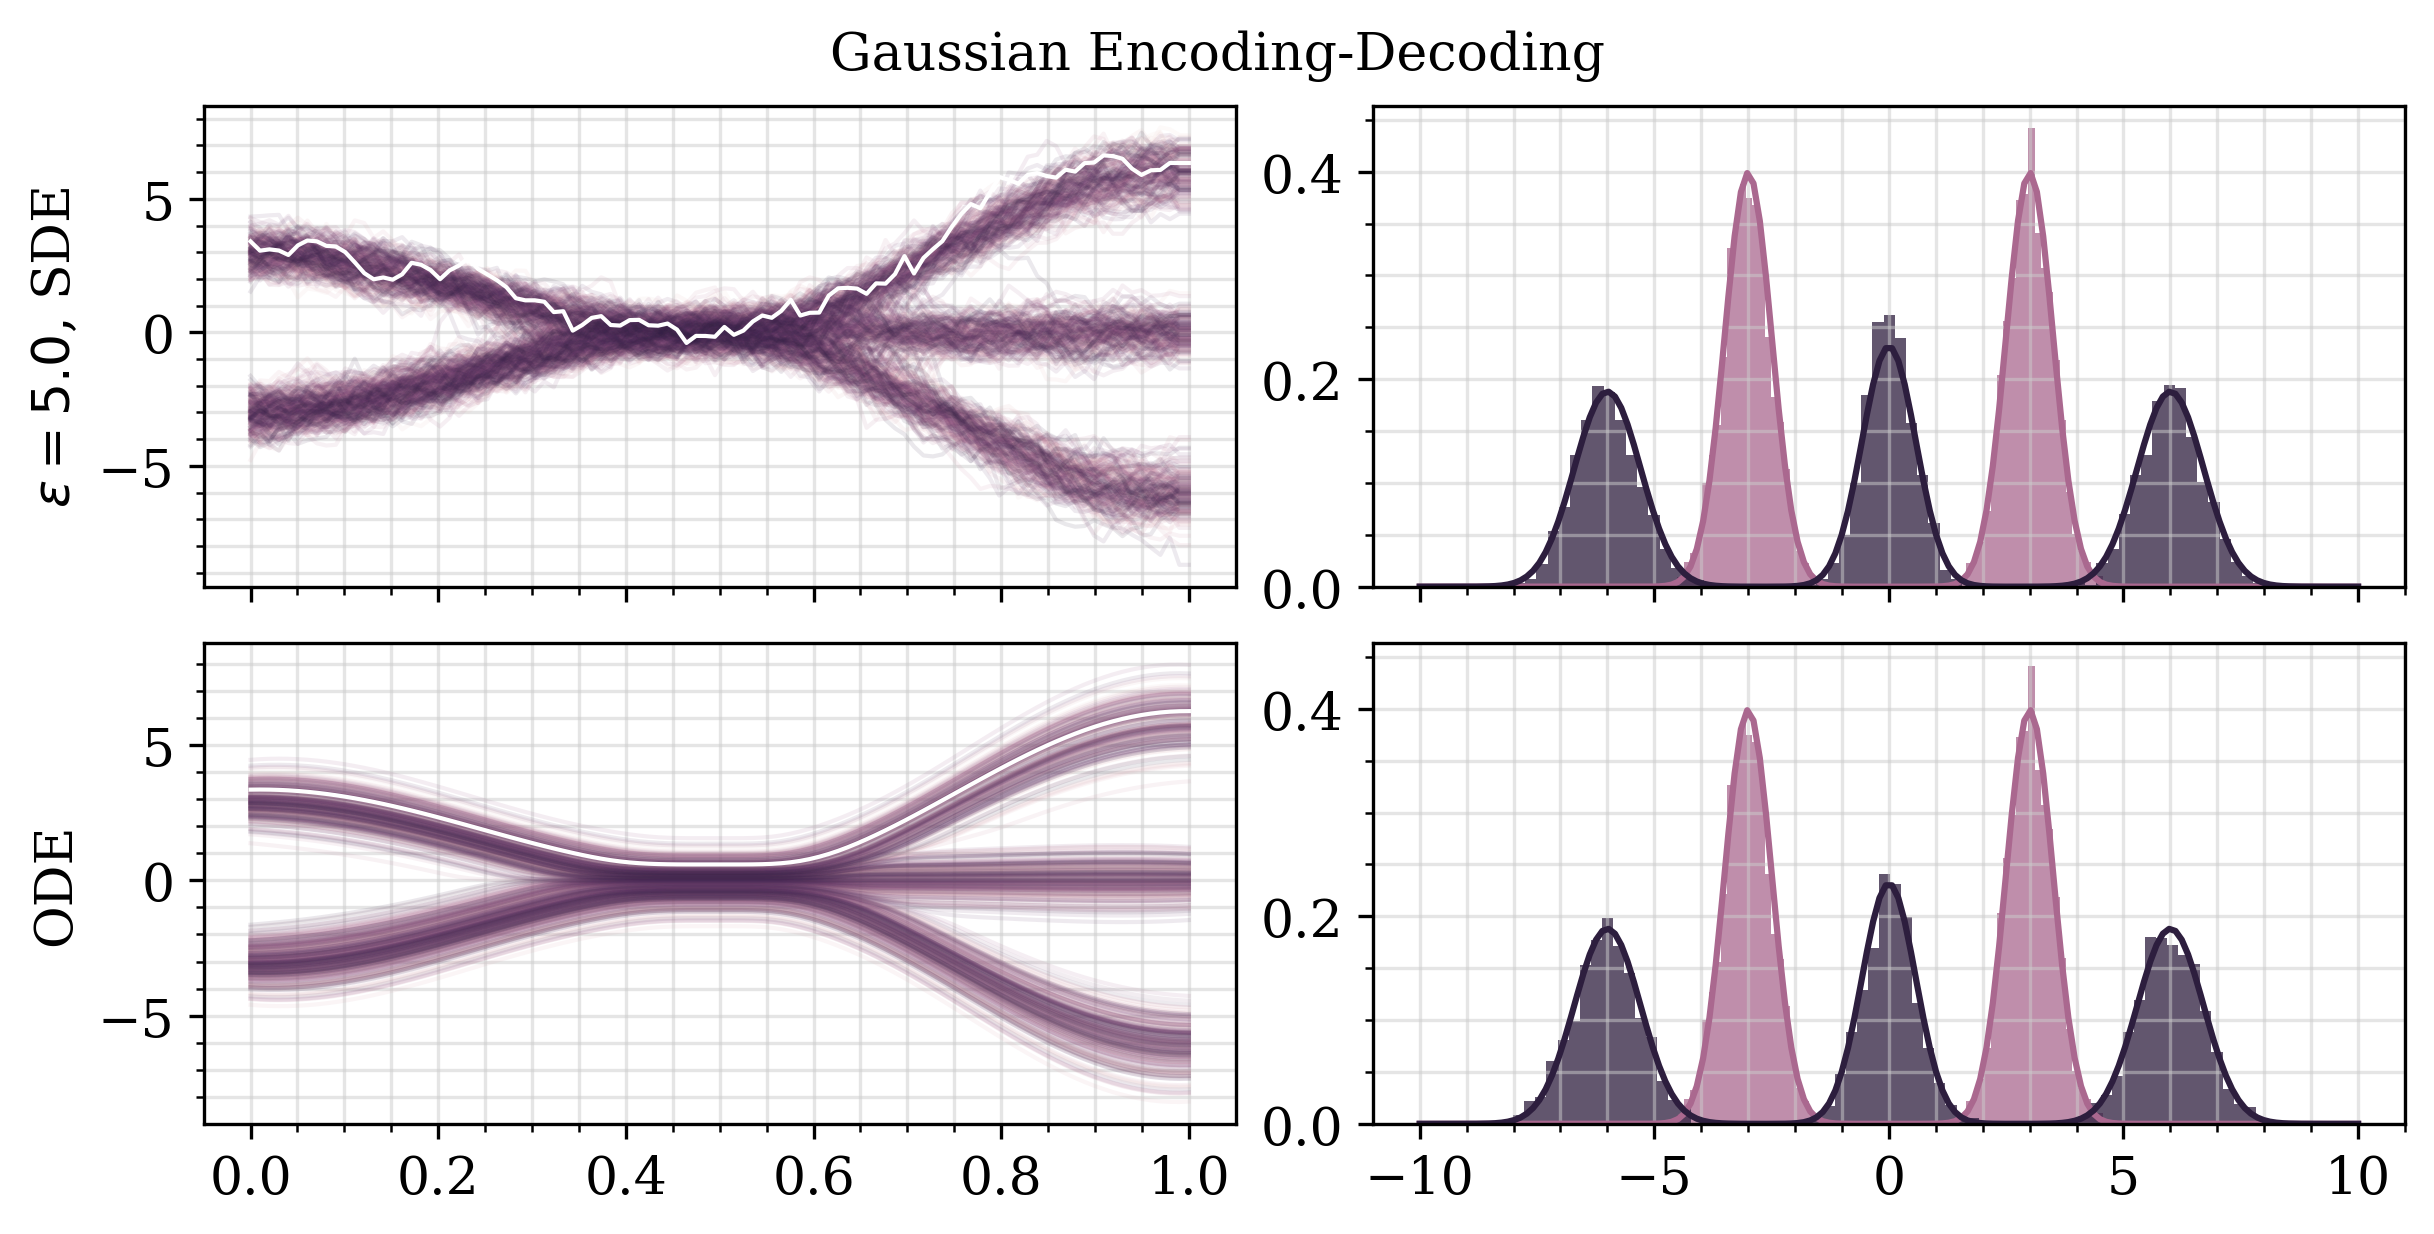

In [15]:
plt.close('all')
plot_skip    = 10
bins         = 'sqrt'
hist_index   = -1
plot_index   = np.random.randint(bs)
fig, axs     = plt.subplots(nrows=2, ncols=2, sharex='col', constrained_layout=True)
t_plots      = np.linspace(0.0, 1.0, n_save)
cmap_trajs   = sns.cubehelix_palette(n_colors=bs//plot_skip)
cmap_dists   = sns.cubehelix_palette(n_colors=3)


# grid for plotting
xs        = torch.linspace(-10, 10, 150).to(device)
rho0      = vmap(interpolant.eval_distribution, in_dims=(None, 0))(torch.tensor(0), xs).cpu().numpy()
rho1      = vmap(interpolant.eval_distribution, in_dims=(None, 0))(torch.tensor(1), xs).cpu().numpy()
fig.suptitle('Gaussian Encoding-Decoding')


# SDE plots
axs[0, 0].set_prop_cycle('color', cmap_trajs)
axs[0, 0].set_ylabel(rf"$\epsilon = {epsilon}$, SDE")
_ = axs[0, 0].plot(t_plots, x1_hats_sde[:, ::plot_skip], lw=1, alpha=0.1)
_ = axs[0, 0].plot(t_plots, x1_hats_sde[:, plot_index],  lw=1, color='white', alpha=1.0)
_ = axs[0, 1].hist(x0s.cpu().numpy(), bins=bins, density=True, color=cmap_dists[1], alpha=0.75)
_ = axs[0, 1].hist(x1_hats_sde[hist_index], bins=bins, density=True, color=cmap_dists[2], alpha=0.75)
_ = axs[0, 1].plot(xs.cpu().numpy(), rho0, color=cmap_dists[1])
_ = axs[0, 1].plot(xs.cpu().numpy(), rho1, color=cmap_dists[2])


# ODE plots
axs[1, 0].set_ylabel(rf"ODE")
axs[1, 0].set_prop_cycle('color', cmap_trajs)

_ = axs[1, 0].plot(t_plots, x1_hats_ode[:, ::plot_skip], lw=1, alpha=0.1)
_ = axs[1, 0].plot(t_plots, x1_hats_ode[:, plot_index],  lw=1, color='white', alpha=1.0)
_ = axs[1, 1].hist(x0s.cpu().numpy(), bins=bins, density=True, color=cmap_dists[1], alpha=0.75)
_ = axs[1, 1].hist(x1_hats_ode[hist_index], bins=bins, density=True, color=cmap_dists[2], alpha=0.75)
_ = axs[1, 1].plot(xs.cpu().numpy(), rho0, color=cmap_dists[1])
_ = axs[1, 1].plot(xs.cpu().numpy(), rho1, color=cmap_dists[2])

#### Distributions over time

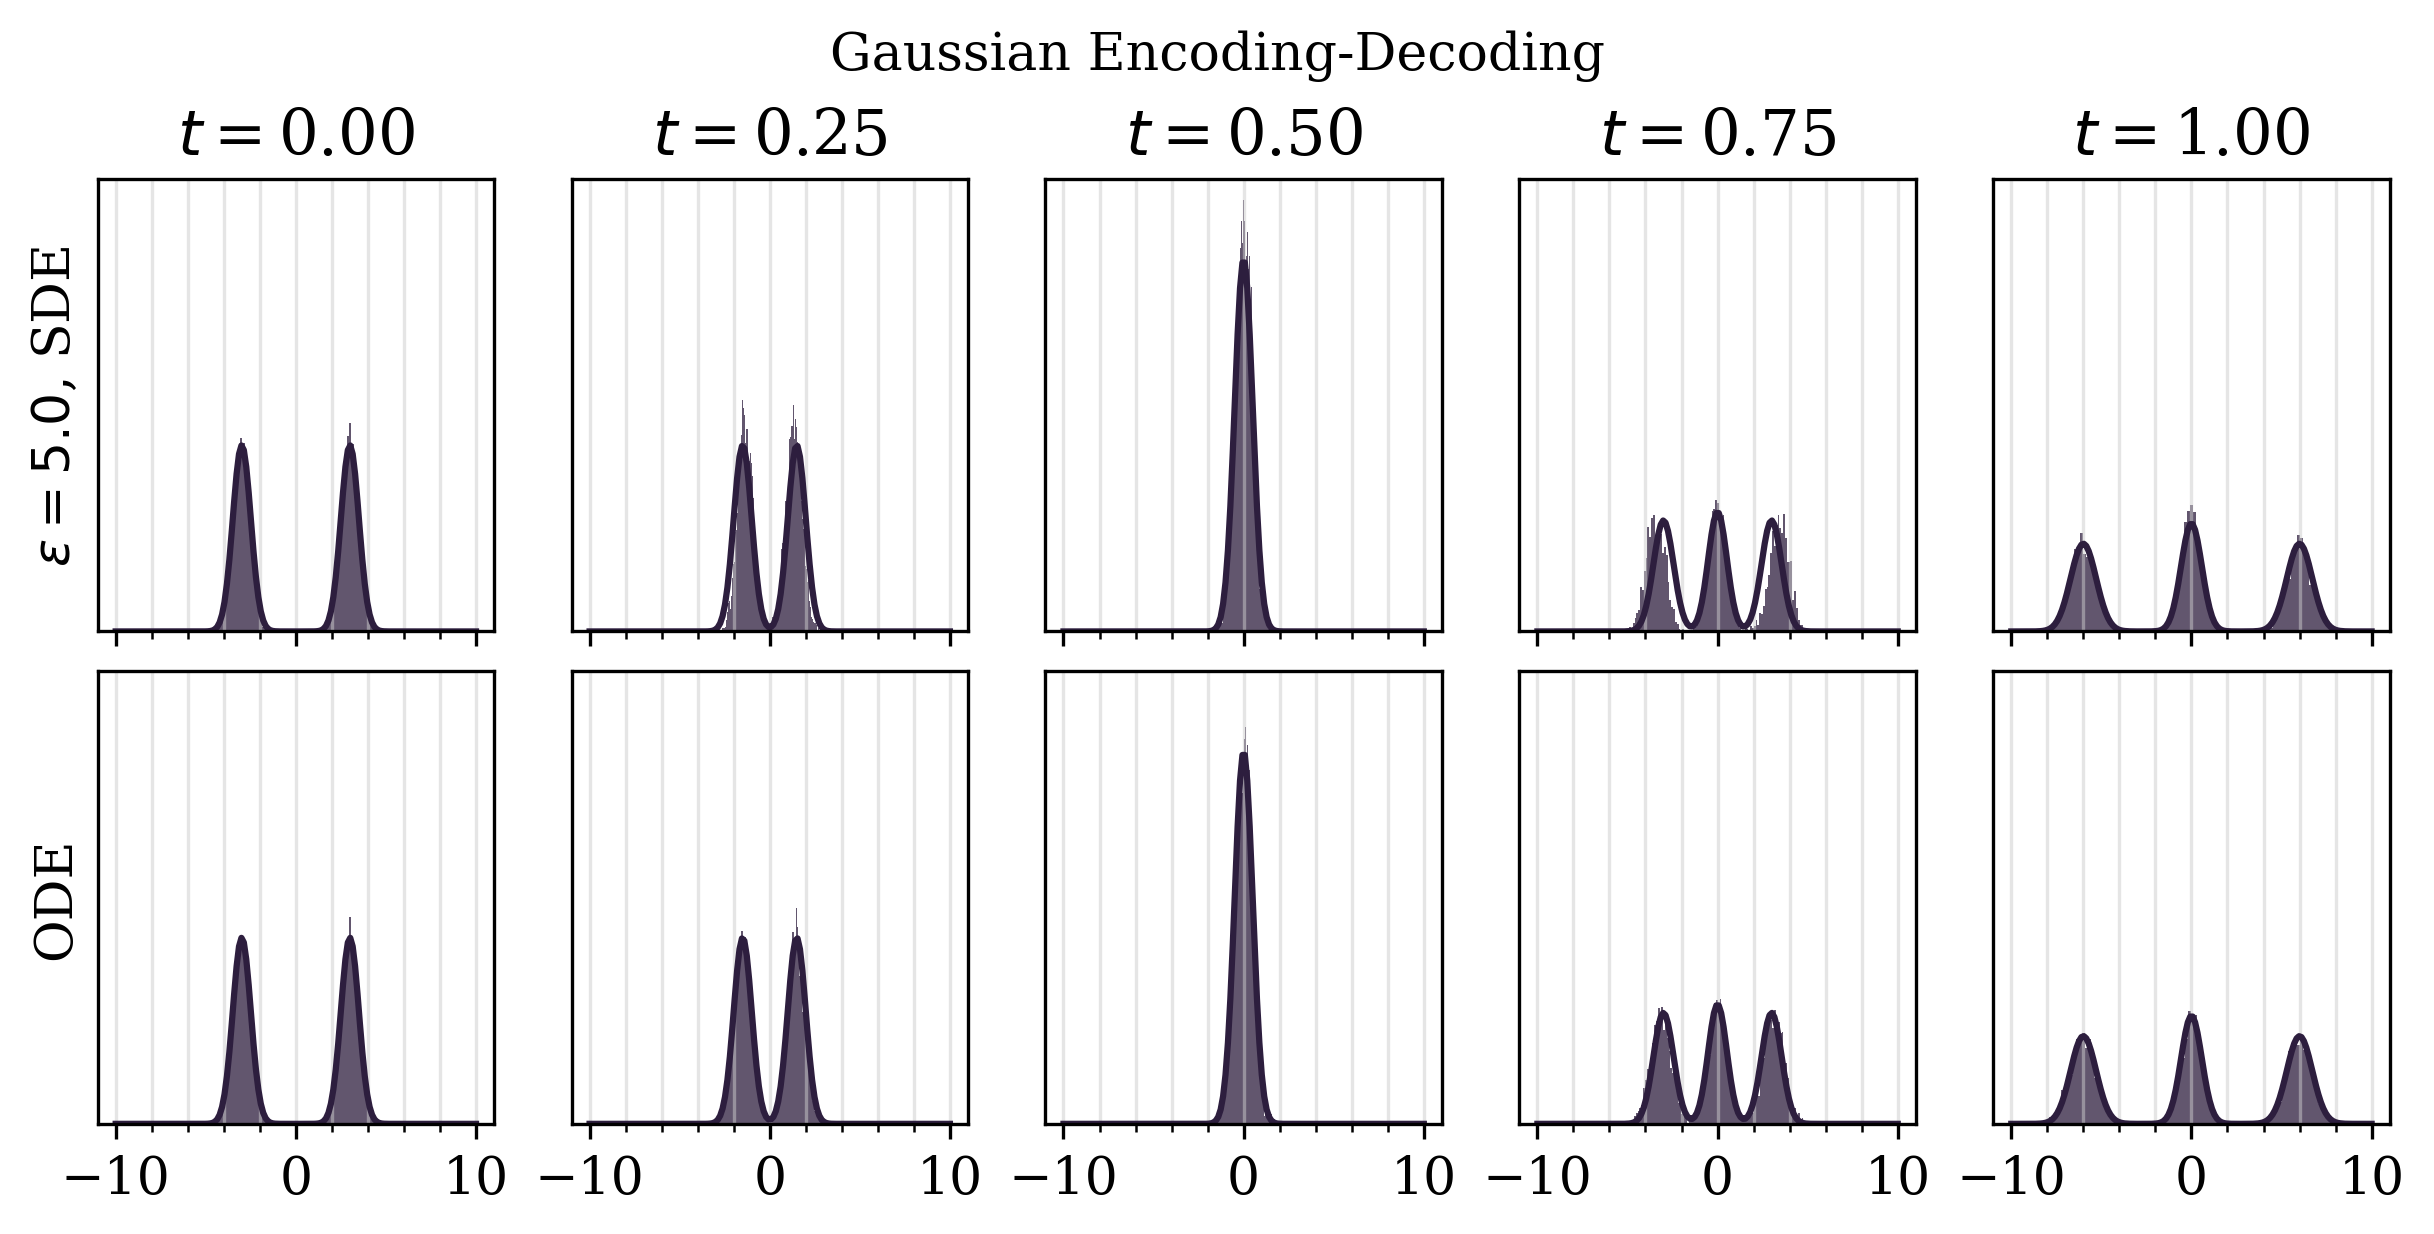

In [16]:
plt.close('all')
plot_skip     = 10
bins          = 100
n_hists       = 5
skip          = x1_hats_sde.shape[0] // (n_hists-1)
hist_indices  = list(np.arange(x1_hats_sde.shape[0])[::skip]) + [x1_hats_sde.shape[0]-1]
total_samples = [x1_hats_sde, x1_hats_ode]
nrows         = len(total_samples)
ncols         = len(hist_indices)
fig, axs      = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, sharex=True, sharey=True)
t_plots       = np.linspace(0.0, 1.0, n_save)
cmap_trajs    = sns.cubehelix_palette(n_colors=bs//plot_skip)
cmap_dists    = sns.cubehelix_palette(n_colors=3)
titles        = [r"$\epsilon = 5.0$, SDE", r"ODE"]


xs = torch.linspace(-10, 10, 150).to(device)
fig.suptitle('Gaussian Encoding-Decoding')
for ii in range(nrows):
    for jj in range(ncols):
        hist_index = hist_indices[jj]
        samples = total_samples[ii][hist_index]
        t = hist_index*dt
        
        if hist_index == hist_indices[-1]:
            t += dt
        
        if ii == 0:
            axs[ii, jj].set_title(f'$t=${t:.02f}')
        
        if jj == 0:
            axs[ii, jj].set_ylabel(titles[ii])
            axs[ii, jj].set_yticks([])
            
        rhot = vmap(interpolant.eval_distribution, in_dims=(None, 0))(t, xs).cpu().numpy()

        _ = axs[ii, jj].hist(samples, bins=bins, density=True, color=cmap_dists[2], alpha=0.75)
        _ = axs[ii, jj].plot(xs.cpu().numpy(), rhot, color=cmap_dists[2])

# Paper Figures

## Spatially Linear: Densities

In [17]:
### Set up the interpolant.
d          = 1
N0         = 2
N1         = 3
p0s        = (torch.ones(N0) / N0).to(device)
p1s        = (torch.ones(N1) / N1).to(device)
mu0s       = torch.tensor([-3.0, 3.0]).reshape((N0, d)).to(device)
C0s        = torch.tensor([0.25, 0.25]).reshape((N0, d, d)).to(device)
mu1s       = torch.tensor([-6.0, 0.0, 6.0]).reshape((N1, d)).to(device)
C1s        = torch.tensor([0.5, 0.33, 0.5]).reshape((N1, d, d)).to(device)
gamma_type = 'brownian'


og = gmm.GMMInterpolant(p0s, p1s, mu0s, mu1s, C0s, C1s, path='trig', gamma_type=gamma_type, device=device)
trig = gmm.GMMInterpolant(p0s, p1s, mu0s, mu1s, C0s, C1s, path='trig', gamma_type=gamma_type, device=device)
encode_decode = gmm.GMMInterpolant(p0s, p1s, mu0s, mu1s, C0s, C1s, path='encoding-decoding', gamma_type=gamma_type, device=device)

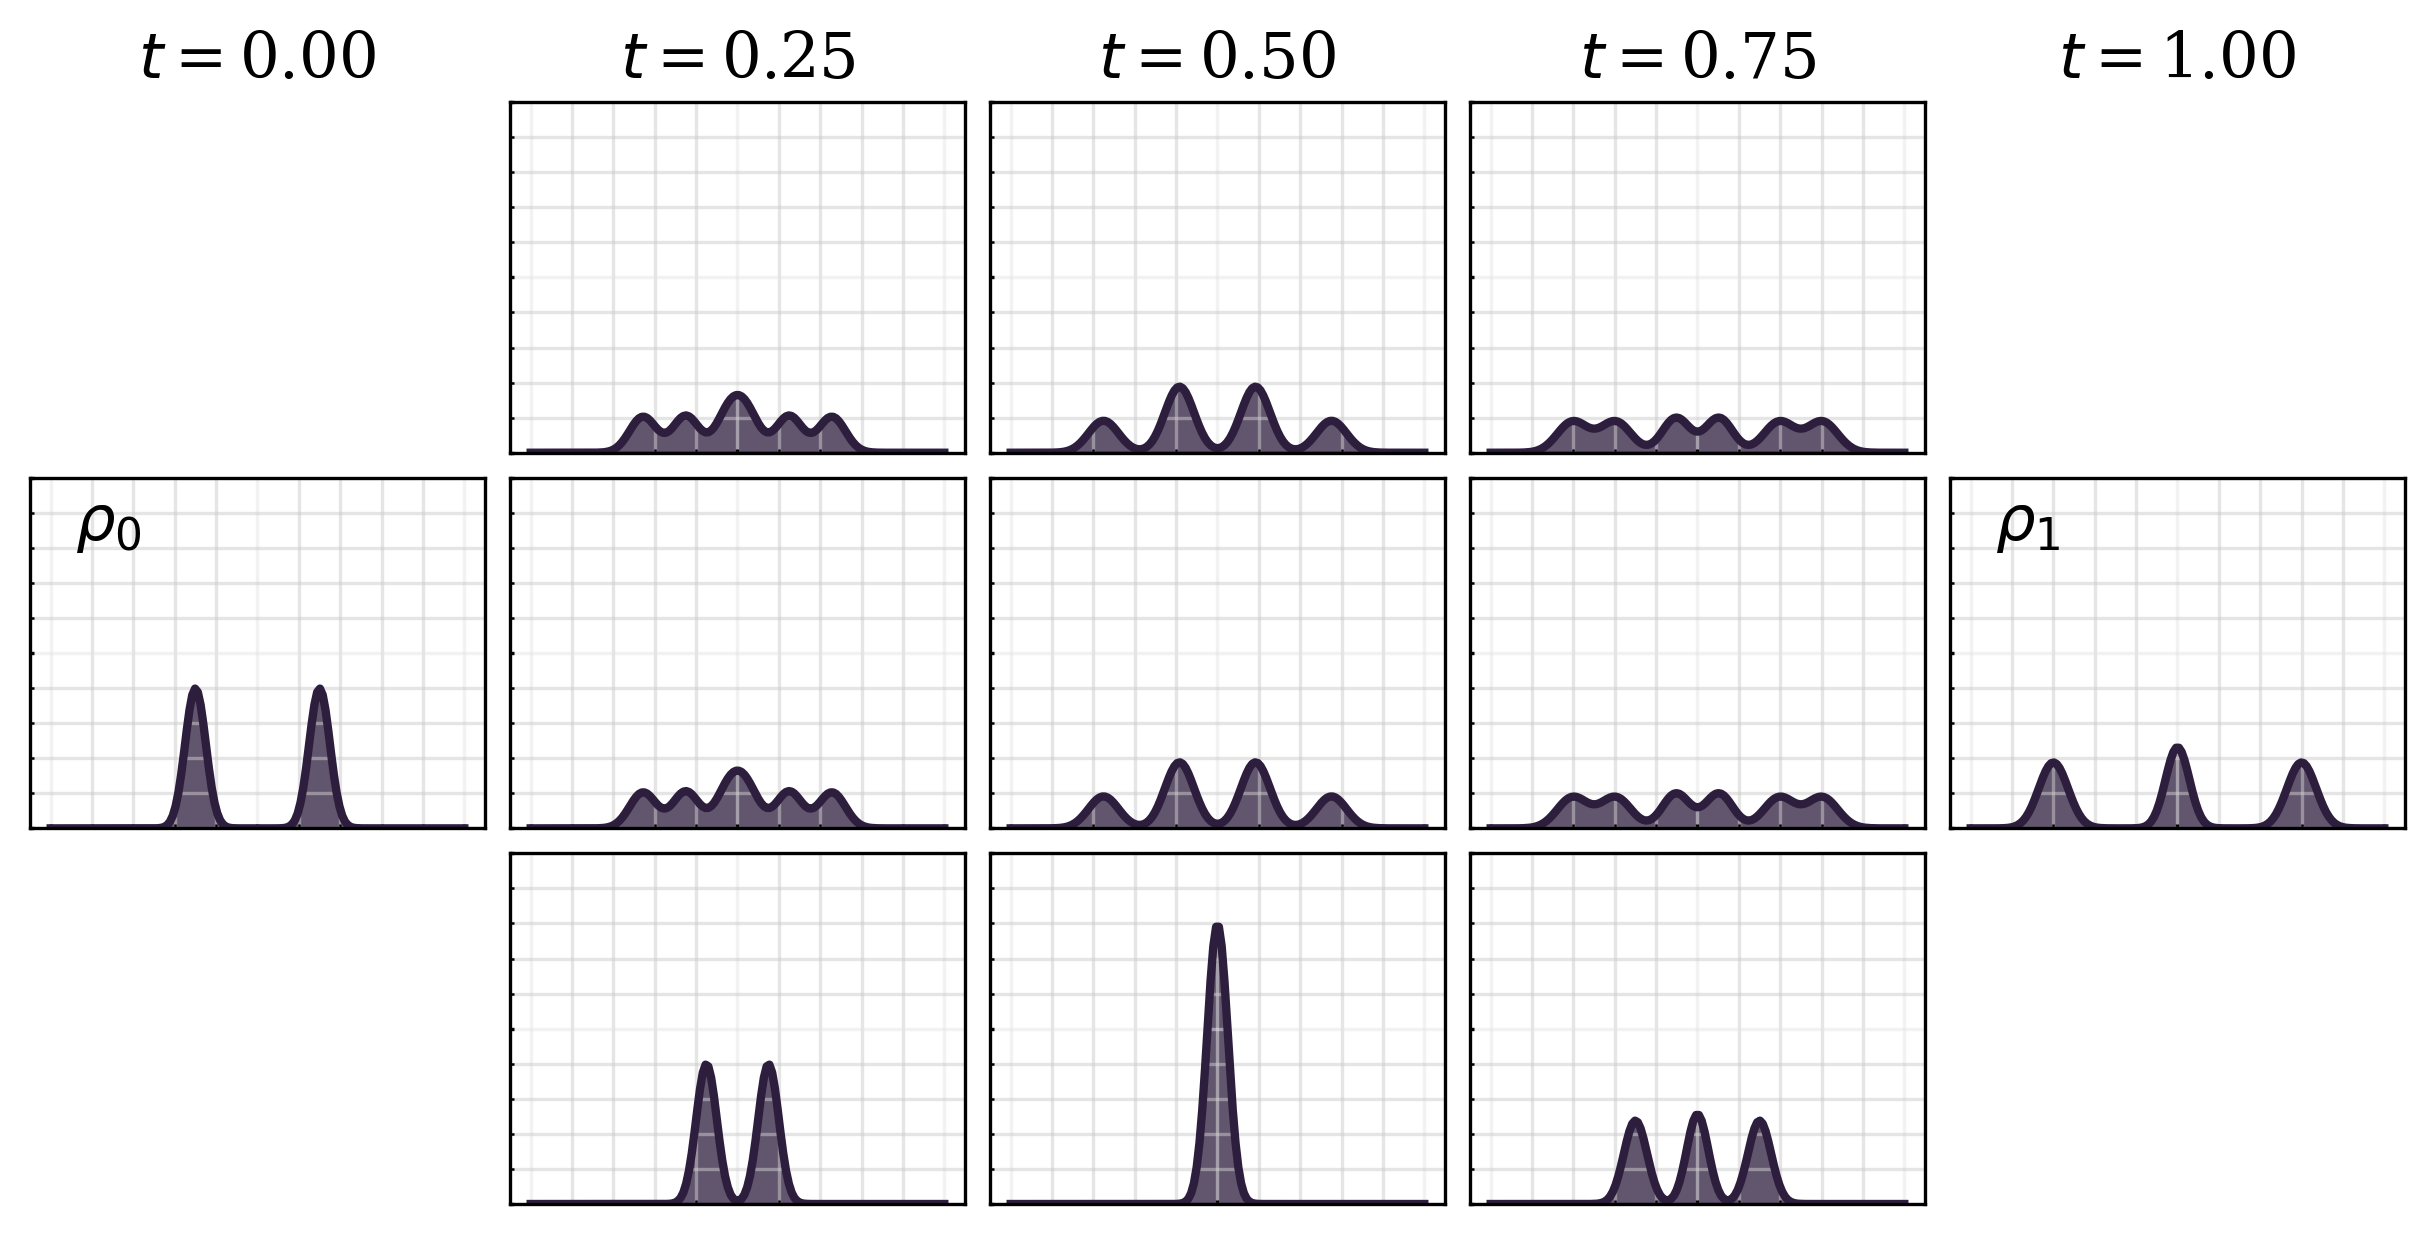

In [18]:
plt.close('all')
t_plots    = [0.0, 0.25, 0.5, 0.75, 1.0]
t_plots    = [torch.tensor(t_plot) for t_plot in t_plots]
gammas     = [r"$\gamma(t)=0$", r"$\gamma(t) = \sqrt{t(1-t)}$", r"$\gamma(t) = \sin^2(\pi t)$"]
interps    = [og, trig, encode_decode]
nrows      = len(interps)
ncols      = len(t_plots)
fig, axs   = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, sharex=True, sharey=True)
cmap_dists = sns.cubehelix_palette(n_colors=5)
color      = cmap_dists[4]
fontsize   = 8
rhosize    = 15


xs = torch.linspace(-10, 10, 150)
for ii in range(nrows):
    interp = interps[ii]
    for jj in range(ncols):
        t = t_plots[jj]
        axs[ii, jj].set_facecolor('white')
        axs[ii, jj].grid(color='0.9', alpha=0.5)
        axs[ii, jj].tick_params(which='both', direction='in', size=1.0)
        axs[ii, jj].set_ylim([0, 1.0])


        # time labels
        if ii == 0:
            axs[ii, jj].set_title(f'$t=${t:.02f}')


        # \rho_0 and \rho_1 labels
        if ii == 1 and jj == 0:
            axs[ii, jj].text(0.1, 0.825, r"$\rho_0$", size=rhosize, transform=axs[ii, jj].transAxes)
        if ii == 1 and jj == (ncols-1):
            axs[ii, jj].text(0.1, 0.825, r"$\rho_1$", size=rhosize, transform=axs[ii, jj].transAxes)


        # make plot
        if (ii == 0 and (jj == 0 or jj == ncols-1)) or (ii == nrows-1 and (jj == 0 or jj == ncols-1)):
            axs[ii, jj].axis('off')
        else:
            t = t.to(device)
            xs = xs.to(device)
            
            rhot = vmap(interp.eval_distribution, in_dims=(None, 0))(t, xs).cpu().numpy()
            _    = axs[ii, jj].plot(xs.cpu().numpy(), rhot, lw=2, color=color)
            axs[ii, jj].fill_between(xs.cpu().numpy(), torch.zeros_like(xs).cpu().numpy(), rhot, color=color, alpha=0.75)
            axs[ii, jj].tick_params(labelleft=False, labelbottom=False)

### Trajectories

In [19]:
### set up the GMM parameters
d     = 1
N0    = 2
N1    = 3
p0s   = (torch.ones(N0) / N0).to(device)
p1s   = (torch.ones(N1) / N1).to(device)
mu0s  = torch.tensor([-3.0, 3.0]).reshape((N0, d)).to(device)
C0s   = torch.tensor([0.25, 0.25]).reshape((N0, d, d)).to(device)
mu1s  = torch.tensor([-6.0, 0.0, 6.0]).reshape((N1, d)).to(device)
C1s   = torch.tensor([0.5, 0.33, 0.5]).reshape((N1, d, d)).to(device)


### set up the interpolants
og = gmm.GMMInterpolant(
    p0s, p1s, mu0s, mu1s, C0s, C1s, path='trig', 
    gamma_type='zero', device=device
)


trig = gmm.GMMInterpolant(
    p0s, p1s, mu0s, mu1s, C0s, C1s, path='trig', 
    gamma_type='brownian', device=device
)


handshake = gmm.GMMInterpolant(
    p0s, p1s, mu0s, mu1s, C0s, C1s, path='encoding-decoding', 
    gamma_type='brownian', device=device
)

In [20]:
### compute the trajectories
ntrajs       = 2500
interps      = [og, trig, encode_decode]
keys         = ['og', 'trig', 'encode_decode']
eps_vals     = [torch.tensor(0.0), torch.tensor(0.5), torch.tensor(5.0)]
# dt           = torch.tensor(5e-3)
n_step       = 200
n_save       = n_step
n_likelihood = 1
start_end    = (0,1)

rslts = {}
with torch.no_grad():
    x0s = og.sample_rho0(ntrajs).to(device)

    for ii, interp in enumerate(interps):
        rslts[keys[ii]] = {}

        for jj, eps in enumerate(eps_vals):
            b, s = interp.get_velocities()
            b, s = fabrics.InputWrapper(b).to(device), fabrics.InputWrapper(s).to(device)
            if eps > 0:
                sde_flow = stochastic_interpolant.SDEIntegrator(b, s, eps, 
                                                                interpolant=interp, 
                                                                n_save=n_save, 
                                                                start_end = start_end, 
                                                                n_step=n_step, 
                                                                n_likelihood=n_likelihood)
                x1s = sde_flow.rollout_forward(x0s, method='heun')
            else:
                
                pflow = stochastic_interpolant.PFlowIntegrator(b, method='rk4', interpolant=interp, n_step=n_save)
                x1s, _ = pflow.rollout(x0s)

            rslts[keys[ii]][f'eps={eps}'] = x1s
            print(f'Finished epsilon={eps} for {keys[ii]}')

Finished epsilon=0.0 for og
Finished epsilon=0.5 for og
Finished epsilon=5.0 for og
Finished epsilon=0.0 for trig
Finished epsilon=0.5 for trig
Finished epsilon=5.0 for trig
Finished epsilon=0.0 for encode_decode
Finished epsilon=0.5 for encode_decode
Finished epsilon=5.0 for encode_decode


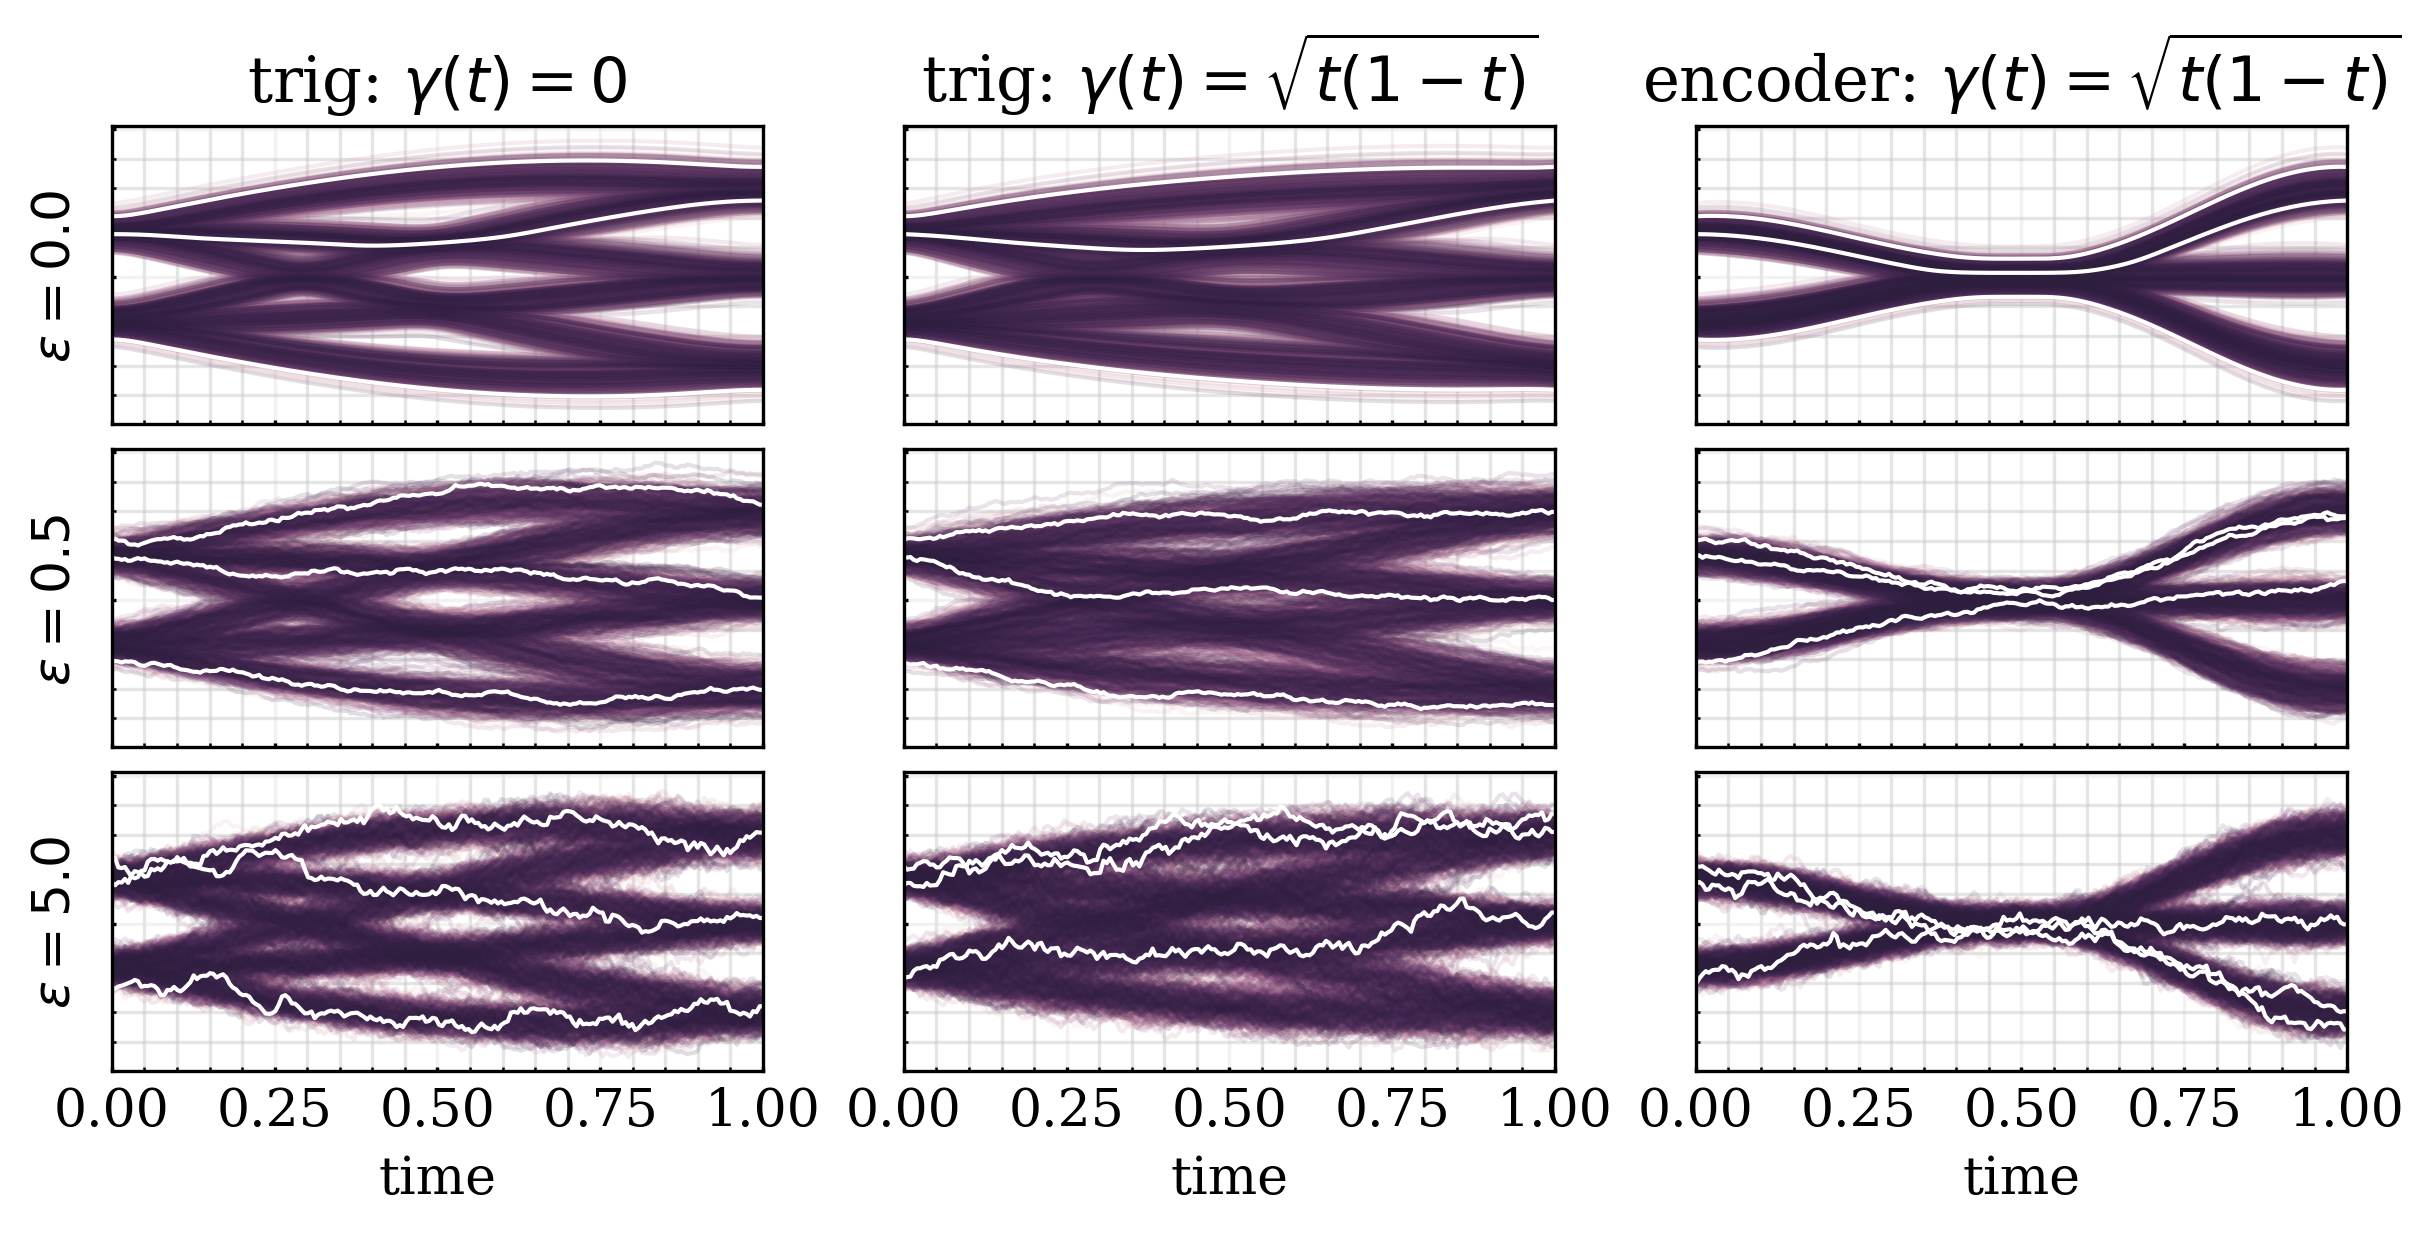

In [21]:
plt.close('all')
nrows     = len(eps_vals)
ncols     = len(interps)
labels    = [r"trig: $\gamma(t)=0$", 
             r"trig: $\gamma(t) = \sqrt{t(1-t)}$", 
             r"encoder: $\gamma(t) = \sqrt{t(1-t)}$"]
fig, axs  = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, sharex=True, sharey=True)
cmap      = sns.cubehelix_palette(n_colors=ntrajs)
t_plots   = np.linspace(0.0, 1.0, n_save)
n_visible = 3
plot_inds = np.random.randint(ntrajs, size=n_visible)


for ii in range(nrows):
    for jj in range(ncols):
        eps = eps_vals[ii]
        axs[ii, jj].set_prop_cycle('color', cmap)
        axs[ii, jj].set_facecolor('white')
        axs[ii, jj].grid(color='0.9', alpha=0.5)
        axs[ii, jj].tick_params(which='both', direction='in', size=1.0)
        axs[ii, jj].set_xlim([0.0, 1.0])
        axs[ii, jj].set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        axs[ii, jj].tick_params(labelleft=False)


        # labels
        if jj == 0:
            axs[ii, jj].set_ylabel(rf"$\epsilon={eps}$")
        if ii == 0:
            axs[ii, jj].set_title(labels[jj])
        if ii == nrows-1:
            axs[ii, jj].set_xlabel('time')

                
        x1s = rslts[keys[jj]][f'eps={eps}']
        axs[ii, jj].plot(t_plots,         x1s[:, :, 0].cpu().data.numpy(), lw=1.0, alpha=0.15, rasterized=True)
        axs[ii, jj].plot(t_plots, x1s[:, plot_inds, 0].cpu().data.numpy(), lw=1.0, color='white')